<a href="https://colab.research.google.com/github/usm1ai/Accident_Prediction/blob/main/Accident_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

In [3]:
conn = sqlite3.connect('/content/drive/MyDrive/Accident Prediction/accident_data_v1.0.0_2023.db')
cursor = conn.cursor()

# Get all the tables in the database
tables = cursor.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()

# Print the table names
for table in tables:
  print(table[0])

accident
casualty
vehicle
lsoa


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
acc_stats = pd.read_sql_query("""
SELECT *
FROM accident
WHERE accident.accident_year = 2020
""", conn)
acc_stats = acc_stats.loc[:,~acc_stats.columns.duplicated()]
acc_stats = acc_stats.drop_duplicates()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
acc_by_whtr = []
whtr = [1,2,3,4,5,6,7,8,9]

for w in whtr:
  cnt = acc_stats[acc_stats['weather_conditions']==w].shape[0]
  acc_by_whtr.append(cnt)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


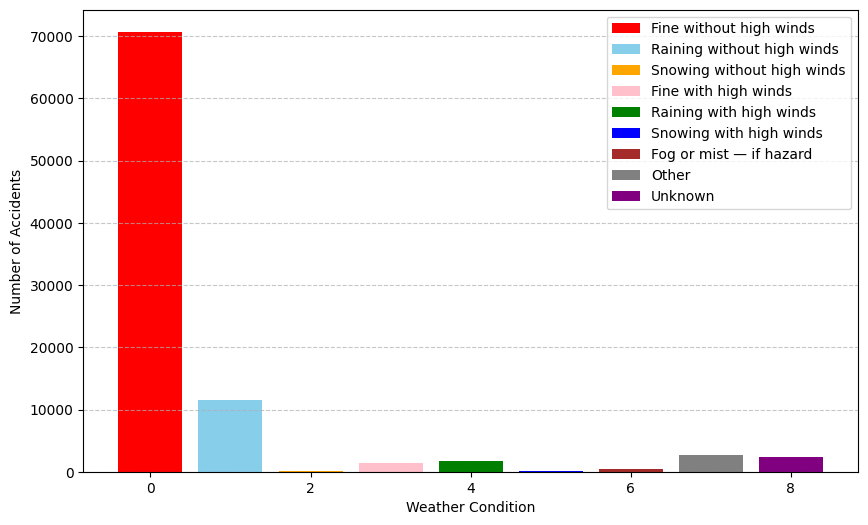

In [7]:
colors = ['red', 'skyblue', 'orange', 'pink', 'green', 'blue', 'brown', 'grey', 'purple']
labels = ['Fine without high winds', 'Raining without high winds', 'Snowing without high winds',
          'Fine with high winds', 'Raining with high winds', 'Snowing with high winds',
          'Fog or mist — if hazard', 'Other', 'Unknown']

plt.figure(figsize=(10, 6))

for i, (acc, color, label) in enumerate(zip(acc_by_whtr, colors, labels)):
  plt.bar(i, acc, color=color, label=label)

plt.xlabel('Weather Condition')
plt.ylabel('Number of Accidents')
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('/content/drive/MyDrive/Accident Prediction/Acc_vs_weather.png')
plt.show()


In [8]:
acc_by_road = []
roads = [1,2,3,6,7,9]

for r in roads:
  cnt = acc_stats[acc_stats['road_type']==r].shape[0]
  acc_by_road.append(cnt)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


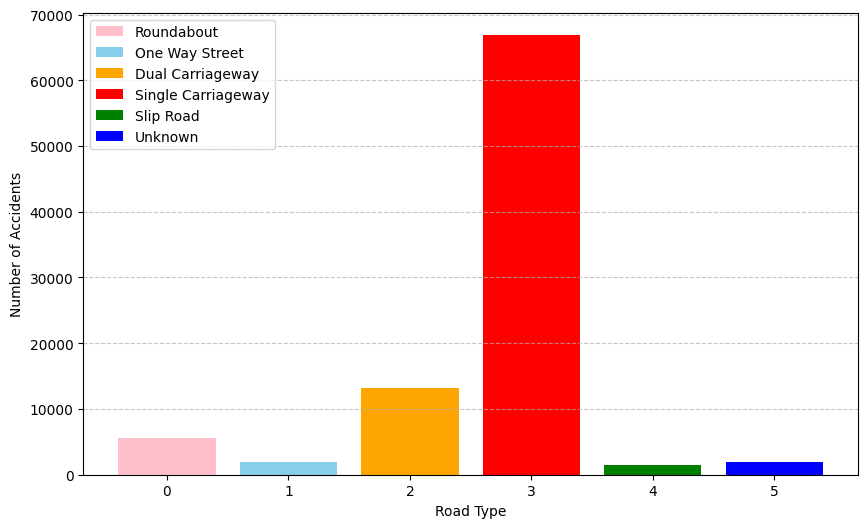

In [9]:
colors = ['pink', 'skyblue', 'orange', 'red', 'green', 'blue']
labels = ['Roundabout', 'One Way Street', 'Dual Carriageway', 'Single Carriageway', 'Slip Road', 'Unknown']

plt.figure(figsize=(10, 6))

for i, (acc, color, label) in enumerate(zip(acc_by_road, colors, labels)):
  plt.bar(i, acc, color=color, label=label)

plt.xlabel('Road Type')
plt.ylabel('Number of Accidents')
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('/content/drive/MyDrive/Accident Prediction/Acc_vs_roadtype.png')
plt.show()


In [14]:
'''
Join accident, casualty, and vehicle tables on accident_index.
Then join the resultant table with lsoa using lsoa_of_accident_location
and lsoa01cd
'''

joined_table = pd.read_sql_query("""
SELECT *
FROM accident
INNER JOIN casualty ON accident.accident_index = casualty.accident_index
INNER JOIN vehicle ON accident.accident_index = vehicle.accident_index
INNER JOIN lsoa ON accident.lsoa_of_accident_location = lsoa.lsoa01cd
WHERE accident.accident_year = 2020
""", conn)

conn.close()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# Delete duplicate columns
joined_table = joined_table.loc[:,~joined_table.columns.duplicated()]
joined_table

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


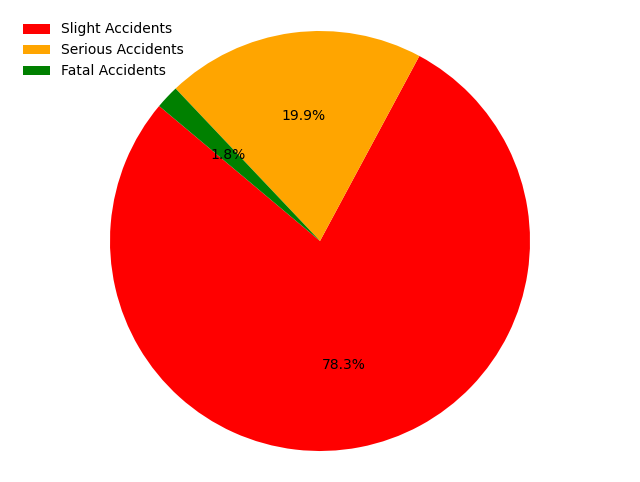

In [17]:
# Calculate the counts of each category in the "accident_severity" column
severity_counts = joined_table['accident_severity'].value_counts()

# Define labels for the pie chart
labels = ['Slight Accidents', 'Serious Accidents', 'Fatal Accidents']
explode = (0.1, 0, 0)  # explode the 1st slice (Fatal)
# Create a pie chart
plt.figure(figsize=(8, 6))
# patches, texts, _ = plt.pie(severity_counts, autopct='%1.1f%%', startangle=140, colors=['red', 'orange', 'green'], explode=explode, shadow=True)
patches, texts, _ = plt.pie(severity_counts, autopct='%1.1f%%', startangle=140, colors=['red', 'orange', 'green'])
# plt.title('Accident Severity Share: 2020')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(patches, labels, loc="best", frameon=False)
plt.savefig('/content/drive/MyDrive/Accident Prediction/Dataset_pie.png')
plt.show()


In [18]:
# # Save file as csv
# joined_table.to_csv('/content/drive/MyDrive/Accident Prediction/joined_table_.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
def time_of_the_day_analysis(time_pred):
  time_pred = pd.DataFrame(time_pred.str.split(':').str[0].astype(int))
  # Count occurrences of accidents for each hour
  hourly_accidents = time_pred.value_counts().sort_index()

  # Plotting
  plt.figure(figsize=(10, 6))
  hourly_accidents.plot(kind='bar', color='skyblue')
  # plt.title('Accidents by Hour of the Day')
  plt.xlabel('Hour')
  plt.ylabel('Number of Accidents')

  # Set the x-axis tick labels
  plt.xticks(range(24), range(0, 24))  # Assuming 24 hours, starting from 1
  plt.xticks(rotation=0)  # Rotate x-axis labels if needed

  plt.grid(axis='y', linestyle='--', alpha=0.7)
  # plt.savefig('/content/drive/MyDrive/Accident Prediction/accidents_by_hour.png')
  plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
def day_of_the_week_analysis(day_pred):
  # Count occurrences of accidents for each hour
  days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
  daily_accidents = day_pred.value_counts().sort_index()

  # Plotting
  plt.figure(figsize=(10, 6))
  daily_accidents.plot(kind='bar', color='skyblue')
  # plt.title('Accidents by Day of the Week')
  plt.xlabel('Day')
  plt.ylabel('Number of Accidents')

  # Set the x-axis tick labels
  # plt.xticks(range(7), range(0, 7))
  plt.xticks(range(7), days)
  plt.xticks(rotation=0)  # Rotate x-axis labels if needed

  plt.grid(axis='y', linestyle='--', alpha=0.7)
  # plt.savefig('/content/drive/MyDrive/Accident Prediction/accidents_by_day.png')
  plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
t = joined_table['time'].copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


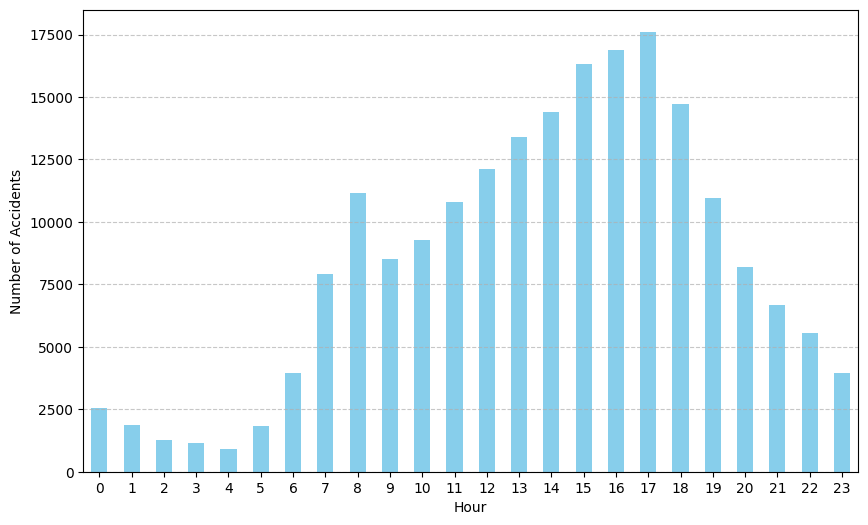

In [22]:
time_of_the_day_analysis(t)

In [23]:
d = joined_table['day_of_week'].copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


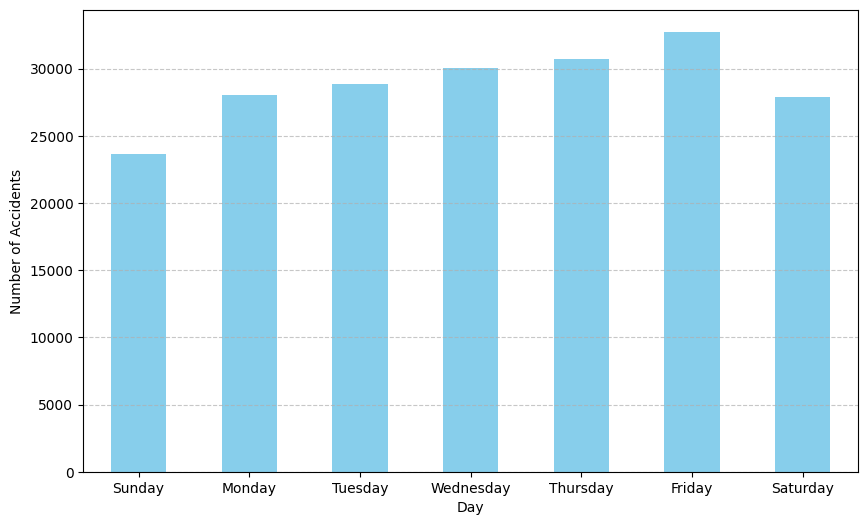

In [24]:
day_of_the_week_analysis(d)

In [25]:
# For Motorcycles

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


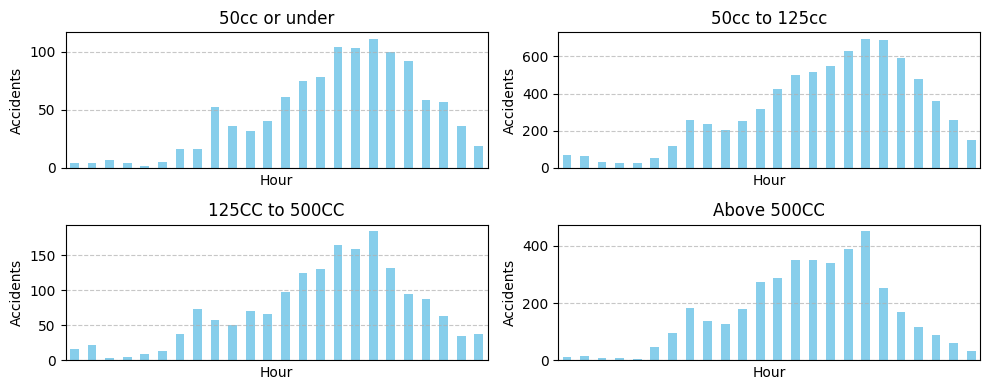

In [26]:
def time_of_the_day_subplots(data, ax, heading):
  data = pd.DataFrame(data.str.split(':').str[0].astype(int))
  hourly_accidents = data.value_counts().sort_index()

  # Plotting
  hourly_accidents.plot(kind='bar', color='skyblue', ax=ax)
  ax.set_title(heading)
  ax.set_xlabel('Hour')
  ax.set_ylabel('Accidents')
  ax.set_xticks([])
  ax.grid(axis='y', linestyle='--', alpha=0.7)


'''
Filter rows where vehicle_type is 2, 3, 4, or 5

2 --> 50CC or under
3 --> 50CC to 125CC
4 --> 125CC to 500CC
5 --> Above 500CC

'''

f_50 = joined_table[joined_table['vehicle_type']==2]
f_50_125 = joined_table[joined_table['vehicle_type']==3]
f_125_500 = joined_table[joined_table['vehicle_type']==4]
f_500 = joined_table[joined_table['vehicle_type']==5]
# Select only the columns of interest
f50_data = f_50[['vehicle_type', 'time', 'day_of_week']].reset_index(drop=True)
f50125_data = f_50_125[['vehicle_type', 'time', 'day_of_week']].reset_index(drop=True)
f125500_data = f_125_500[['vehicle_type', 'time', 'day_of_week']].reset_index(drop=True)
f500_data = f_500[['vehicle_type', 'time', 'day_of_week']].reset_index(drop=True)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 4))

# Plot each dataset in a subplot
time_of_the_day_subplots(f50_data['time'], axes[0,0], '50cc or under')
time_of_the_day_subplots(f50125_data['time'], axes[0,1], '50cc to 125cc')
time_of_the_day_subplots(f125500_data['time'], axes[1,0], '125CC to 500CC')
time_of_the_day_subplots(f500_data['time'], axes[1,1], 'Above 500CC')

# Adjust layout
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


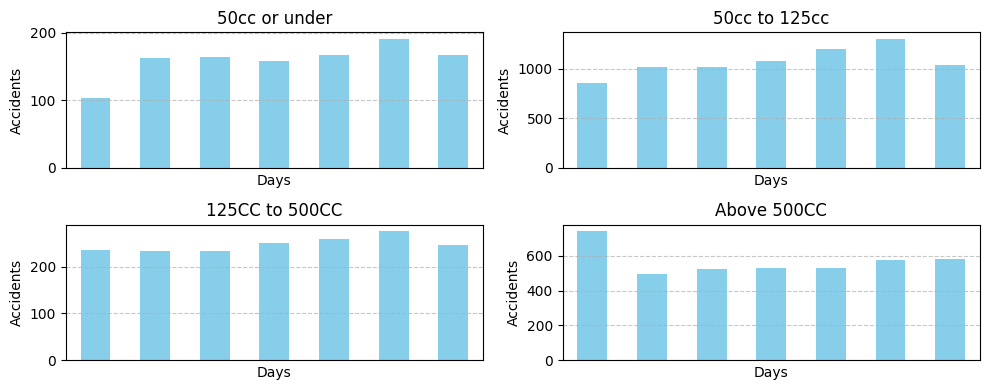

In [27]:
def day_of_week_subplots(data, ax, heading):
  days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
  daily_accidents = data.value_counts().sort_index()

  # Plotting
  daily_accidents.plot(kind='bar', color='skyblue', ax=ax)
  ax.set_title(heading)
  ax.set_xlabel('Days')
  ax.set_ylabel('Accidents')
  ax.set_xticks([])
  ax.grid(axis='y', linestyle='--', alpha=0.7)


'''
Filter rows where vehicle_type is 2, 3, 4, or 5

2 --> 50CC or under
3 --> 50CC to 125CC
4 --> 125CC to 500CC
5 --> Above 500CC

'''

f_50 = joined_table[joined_table['vehicle_type']==2]
f_50_125 = joined_table[joined_table['vehicle_type']==3]
f_125_500 = joined_table[joined_table['vehicle_type']==4]
f_500 = joined_table[joined_table['vehicle_type']==5]
# Select only the columns of interest
f50_data = f_50[['vehicle_type', 'time', 'day_of_week']].reset_index(drop=True)
f50125_data = f_50_125[['vehicle_type', 'time', 'day_of_week']].reset_index(drop=True)
f125500_data = f_125_500[['vehicle_type', 'time', 'day_of_week']].reset_index(drop=True)
f500_data = f_500[['vehicle_type', 'time', 'day_of_week']].reset_index(drop=True)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 4))

# Plot each dataset in a subplot
day_of_week_subplots(f50_data['day_of_week'], axes[0,0], '50cc or under')
day_of_week_subplots(f50125_data['day_of_week'], axes[0,1], '50cc to 125cc')
day_of_week_subplots(f125500_data['day_of_week'], axes[1,0], '125CC to 500CC')
day_of_week_subplots(f500_data['day_of_week'], axes[1,1], 'Above 500CC')

# Adjust layout
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
'''
Filter rows where pedestrian_location is not 0
'''

filtered_table = joined_table[joined_table['pedestrian_location'] !=0]
# Select only the columns of interest
filtered_data = filtered_table[['pedestrian_location', 'time', 'day_of_week']].reset_index(drop=True)
# Display the filtered data
filtered_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,pedestrian_location,time,day_of_week
0,9,09:00,3
1,1,13:55,2
2,1,13:55,2
3,5,01:25,4
4,4,01:50,4
...,...,...,...
14207,1,15:30,2
14208,5,16:50,5
14209,5,08:30,4
14210,9,15:25,5


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


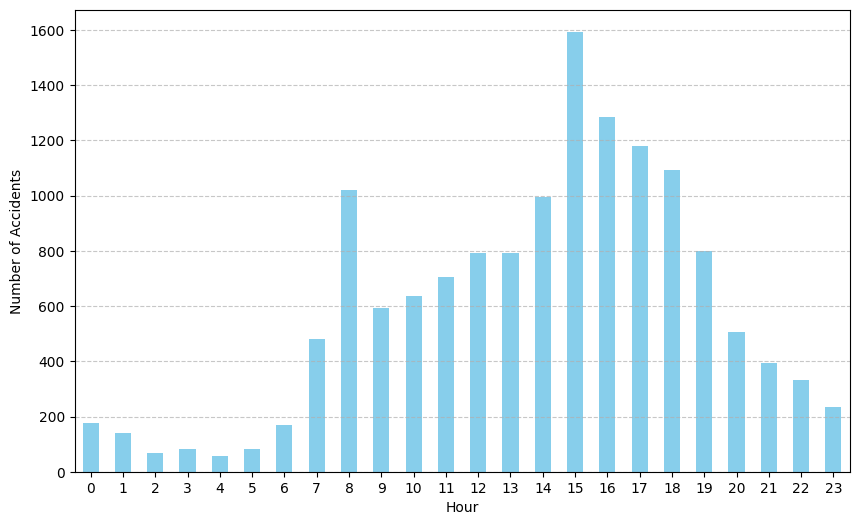

In [29]:
time_of_the_day_analysis(filtered_data['time'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


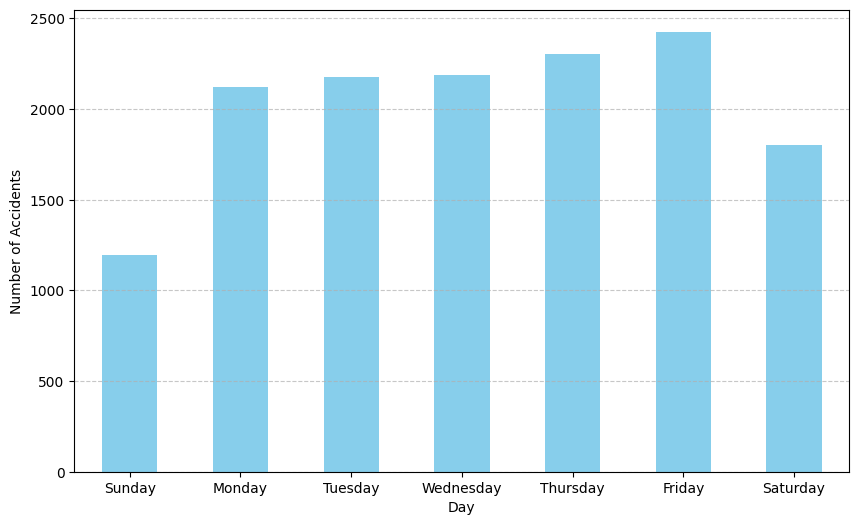

In [30]:
day_of_the_week_analysis(filtered_data['day_of_week'])

In [31]:
severity_data = joined_table[['time', 'day_of_week', 'pedestrian_location', 'accident_severity']]

severity_data['time'] = severity_data['time'].str.split(':').str[0].astype(int)
# Drop accident_severity column from features
features = severity_data.drop(columns=['accident_severity'])

# Convert categorical variables to one-hot encoded format
df_time = pd.get_dummies(severity_data['time'], prefix='time')
df_dow = pd.get_dummies(severity_data['day_of_week'], prefix='dow')
df_pl = pd.get_dummies(severity_data['pedestrian_location'], prefix='pl')
df_sev = pd.get_dummies(severity_data['accident_severity'], prefix='sev')

df_encoded = pd.concat([df_time, df_dow, df_pl, df_sev], axis=1)

# Find frequent itemsets with minimum support threshold
frequent_itemsets = apriori(df_encoded, min_support=0.1, use_colnames=True)
# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

# Display frequent itemsets and association rules
# print("Frequent Itemsets:")
# print(frequent_itemsets)
# print("\nAssociation Rules:")
# print(rules)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-31-230f58f49319>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  severity_data['time'] = severity_data['time'].str.split(':').str[0].astype(int)


In [32]:
rules

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(dow_1),(pl_0),0.116939,0.929624,0.111031,0.949481,1.021361,0.002322,1.393073,0.023684
1,(dow_2),(pl_0),0.138935,0.929624,0.128432,0.924404,0.994385,-0.000725,0.930951,-0.006515
2,(dow_2),(sev_3),0.138935,0.782676,0.110323,0.794062,1.014547,0.001582,1.055287,0.016652
3,(dow_3),(pl_0),0.142961,0.929624,0.132181,0.924593,0.994588,-0.000719,0.933286,-0.006309
4,(dow_3),(sev_3),0.142961,0.782676,0.113497,0.793904,1.014345,0.001605,1.054477,0.016501
5,(dow_4),(pl_0),0.148695,0.929624,0.137851,0.927068,0.997251,-0.000380,0.964959,-0.003228
6,(dow_4),(sev_3),0.148695,0.782676,0.117652,0.791228,1.010926,0.001272,1.040963,0.012696
7,(dow_5),(pl_0),0.152221,0.929624,0.140822,0.925114,0.995149,-0.000686,0.939777,-0.005717
8,(dow_5),(sev_3),0.152221,0.782676,0.119316,0.783832,1.001477,0.000176,1.005347,0.001739
9,(dow_6),(pl_0),0.162140,0.929624,0.150122,0.925877,0.995970,-0.000607,0.949457,-0.004806


In [34]:
rules.to_csv('/content/drive/MyDrive/Accident Prediction/apriori_rules.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
frequent_itemsets

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets
0,0.116939,(dow_1)
1,0.138935,(dow_2)
2,0.142961,(dow_3)
3,0.148695,(dow_4)
4,0.152221,(dow_5)
5,0.162140,(dow_6)
6,0.138108,(dow_7)
7,0.929624,(pl_0)
8,0.199140,(sev_2)
9,0.782676,(sev_3)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
# Define the list of region substrings
regions = ['Kingston upon Hull', 'East Riding of Yorkshire', 'North Lincolnshire', 'North East Lincolnshire']

# Filter rows where 'lsoa01nm' contains any of the region substrings
filtered_table = joined_table[joined_table['lsoa01nm'].str.contains('|'.join(regions))]

# Select only the columns of interest
filtered_data = filtered_table[['longitude', 'latitude', 'lsoa01nm']].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
filtered_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,longitude,latitude,lsoa01nm
0,-0.393424,53.744936,Kingston upon Hull 028E
1,-0.393424,53.744936,Kingston upon Hull 028E
2,-0.528743,53.512895,North Lincolnshire 022C
3,-0.324858,53.791630,Kingston upon Hull 002E
4,-0.095008,53.574501,North East Lincolnshire 003C
...,...,...,...
3980,-0.703181,53.569801,North Lincolnshire 005A
3981,-0.703181,53.569801,North Lincolnshire 005A
3982,-0.703181,53.569801,North Lincolnshire 005A
3983,-0.342063,53.742609,Kingston upon Hull 029C


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


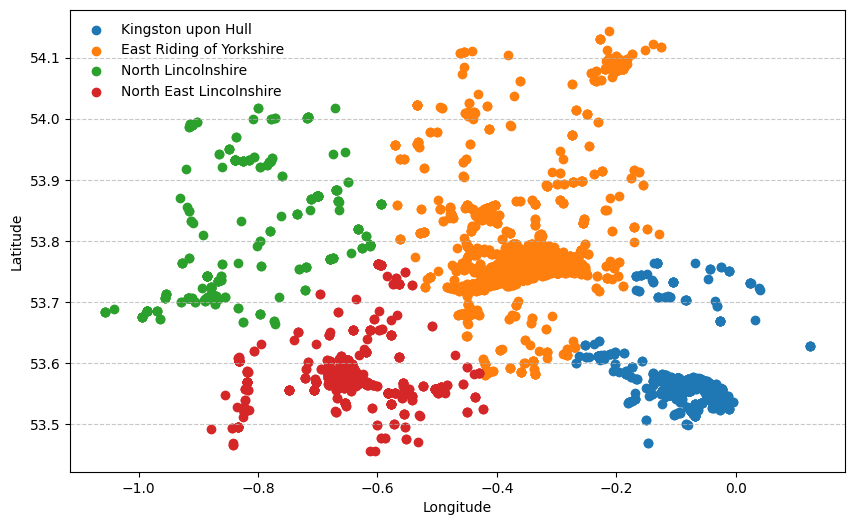

In [36]:
# Define the number of clusters
num_clusters = 4

# Select longitude and latitude columns for clustering
X = filtered_data[['longitude', 'latitude']]

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Add cluster labels to the DataFrame
filtered_data['cluster'] = kmeans.labels_

# Define region names
regions = ['Kingston upon Hull', 'East Riding of Yorkshire', 'North Lincolnshire', 'North East Lincolnshire']

# Create a dictionary to map cluster labels to region names
cluster_region_map = {cluster_label: region for cluster_label, region in zip(range(num_clusters), regions)}

# Map cluster labels to region names
filtered_data['region'] = filtered_data['cluster'].map(cluster_region_map)

# Plot the clusters
plt.figure(figsize=(10, 6))
for region in regions:
    region_data = filtered_data[filtered_data['region'] == region]
    plt.scatter(region_data['longitude'], region_data['latitude'], label=region)

# plt.title('Accident Clusters in Specified Regions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(frameon=False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [37]:
severity_data = joined_table[['number_of_vehicles', 'number_of_casualties', 'accident_severity']]
severity_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,number_of_vehicles,number_of_casualties,accident_severity
0,1,1,3
1,1,2,3
2,1,2,3
3,1,1,3
4,1,1,2
...,...,...,...
201938,4,6,1
201939,4,6,1
201940,4,6,1
201941,4,6,1


In [38]:
severity_data[severity_data['accident_severity']==1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,number_of_vehicles,number_of_casualties,accident_severity
37,1,1,1
162,1,1,1
180,2,1,1
181,2,1,1
683,1,1,1
...,...,...,...
201938,4,6,1
201939,4,6,1
201940,4,6,1
201941,4,6,1


In [39]:
# Select the columns for outlier detection
X = severity_data[['number_of_vehicles', 'number_of_casualties', 'accident_severity']]

# Fit the Elliptic Envelope model
envelope = EllipticEnvelope(contamination=0.0005)  # Adjust contamination based on expected proportion of outliers
envelope.fit(X)

# Predict outliers
outliers = envelope.predict(X)

# Add outlier predictions to the DataFrame
severity_data['is_outlier'] = outliers

# Print the outliers
print("Outliers:")
print(severity_data[severity_data['is_outlier'] == -1])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Outliers:
        number_of_vehicles  number_of_casualties  accident_severity  \
79075                    1                    17                  3   
79076                    1                    17                  3   
79077                    1                    17                  3   
79078                    1                    17                  3   
79079                    1                    17                  3   
...                    ...                   ...                ...   
166712                   2                    13                  2   
166713                   2                    13                  2   
166714                   2                    13                  2   
166715                   2                    13                  2   
166716                   2                    13                  2   

        is_outlier  
79075           -1  
79076           -1  
79077           -1  
79078           -1  
79079           -1  
...        

<ipython-input-39-b1b206a67021>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  severity_data['is_outlier'] = outliers


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


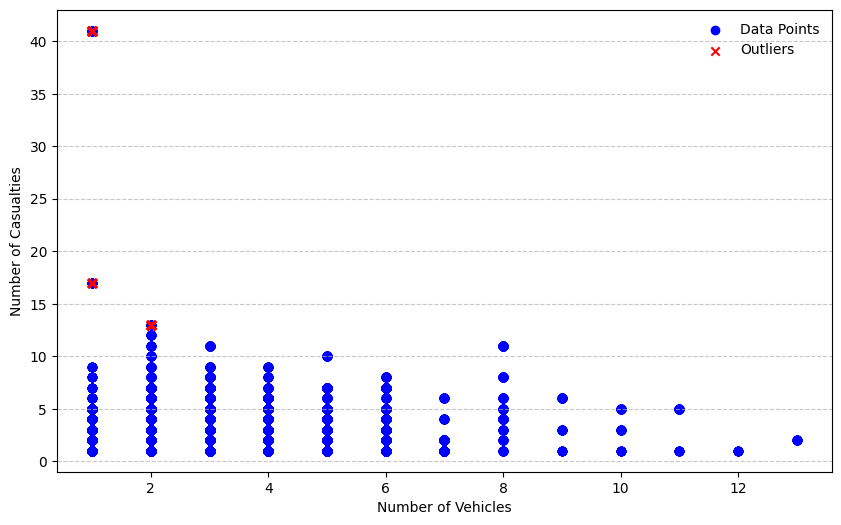

In [43]:
# Scatter plot of the entire dataset
plt.figure(figsize=(10, 6))
plt.scatter(severity_data['number_of_vehicles'], severity_data['number_of_casualties'], c='blue', label='Data Points')

# Highlight outliers
outliers = severity_data[severity_data['is_outlier'] == -1]
plt.scatter(outliers['number_of_vehicles'], outliers['number_of_casualties'], c='red', label='Outliers', marker='x')

# plt.title('Accident Severity Analysis')
plt.xlabel('Number of Vehicles')
plt.ylabel('Number of Casualties')
plt.legend(frameon=False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
injuries_data = joined_table[['number_of_vehicles', 'number_of_casualties', 'road_type', 'junction_detail',
                              'pedestrian_crossing_human_control', 'pedestrian_crossing_physical_facilities',
                              'light_conditions', 'weather_conditions', 'time', 'day_of_week', 'speed_limit',
                              'junction_control', 'road_surface_conditions', 'special_conditions_at_site', 'pedestrian_location',
                              'pedestrian_movement', 'accident_severity']]
injuries_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,number_of_vehicles,number_of_casualties,road_type,junction_detail,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,time,day_of_week,speed_limit,junction_control,road_surface_conditions,special_conditions_at_site,pedestrian_location,pedestrian_movement,accident_severity
0,1,1,6,0,9,9,1,9,09:00,3,20,-1,9,0,9,5,3
1,1,2,6,9,0,4,1,1,13:55,2,20,2,1,0,1,1,3
2,1,2,6,9,0,4,1,1,13:55,2,20,2,1,0,1,1,3
3,1,1,6,3,0,0,4,1,01:25,4,30,1,2,0,5,9,3
4,1,1,6,0,0,4,4,1,01:50,4,30,-1,1,0,4,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201938,4,6,6,0,0,0,6,1,17:30,7,60,-1,2,0,0,0,1
201939,4,6,6,0,0,0,6,1,17:30,7,60,-1,2,0,0,0,1
201940,4,6,6,0,0,0,6,1,17:30,7,60,-1,2,0,0,0,1
201941,4,6,6,0,0,0,6,1,17:30,7,60,-1,2,0,0,0,1


In [45]:
injuries_data['time'] = injuries_data['time'].str.split(':').str[0].astype(int)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-45-24c0c8716c98>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  injuries_data['time'] = injuries_data['time'].str.split(':').str[0].astype(int)


In [46]:
# Separate samples for each class
fatal = injuries_data[injuries_data['accident_severity'] == 1]
serious = injuries_data[injuries_data['accident_severity'] == 2]
slight = injuries_data[injuries_data['accident_severity'] == 3]

# Downsample classes with more samples
n_samples = 3672  # Number of samples to collect from each class

serious_downsampled = resample(serious, replace=False, n_samples=n_samples, random_state=42)
slight_downsampled = resample(slight, replace=False, n_samples=n_samples, random_state=42)

# Combine all classes
balanced_data = pd.concat([fatal, serious_downsampled, slight_downsampled])

# Shuffle the dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Check class distribution
print(balanced_data['accident_severity'].value_counts())


accident_severity
3    3672
1    3672
2    3672
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
# Prepare the data
X = balanced_data.drop(columns=['accident_severity'])  # Features
y = balanced_data['accident_severity']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Initialize the Random Forest Classifier model
rf_classifier = RandomForestClassifier(n_estimators=10, random_state=42)

# Train the model on the training data
rf_classifier.fit(X_train, y_train)

# Predict accident severity on the testing data
y_pred = rf_classifier.predict(X_test)

curr = accuracy_score(y_test, y_pred)

# Evaluate the model's performance
print(f"Accuracy: {curr}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6733212341197822

Classification Report:
               precision    recall  f1-score   support

           1       0.77      0.90      0.83       537
           2       0.59      0.57      0.58       544
           3       0.64      0.56      0.60       572

    accuracy                           0.67      1653
   macro avg       0.67      0.68      0.67      1653
weighted avg       0.67      0.67      0.67      1653



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


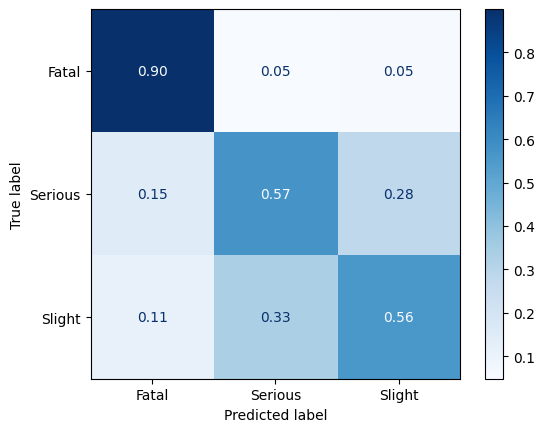

In [50]:
# Convert target labels to numerical values
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_pred_encoded = label_encoder.transform(y_pred)

label_mapping = {1: 'Fatal', 2: 'Serious', 3: 'Slight'}

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_encoded, normalize='true')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=[label_mapping[i] for i in label_encoder.classes_])
disp.plot(cmap=plt.cm.Blues, values_format='.2f')
# plt.title('Normalized Confusion Matrix')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
